# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Цель исследования** - построить лучшую модель, учитывая 3 параметра: скорость обучения, скорость предсказания, точность предсказания.

**Ход исследования**

Данные об автомобилях получим из файла `autos.csv`. О качестве данных ничего неизвестно, поэтому будем производить осмотр данных и, если потребуется, предобработку данных.

Таким образом, исследование пройдет в 4 этапа:
1. Осмотр данных;
2. Предобработка данных;
3. Обучение моделей;
4. Анализ моделей.

## Осмотр данных

In [1]:
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 65)
sns.set(style="whitegrid")

from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import Dataset, LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

Загрузим данные

In [2]:
data = pd.read_csv('/datasets/autos.csv')

Посмотрим на 10 случайных наблюдений из данных.

In [3]:
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
289474,2016-03-07 18:53:54,1000,NaN,2017,manual,80,NaN,150000,0,NaN,fiat,no,2016-03-07 00:00:00,0,94447,2016-03-07 18:53:54
80780,2016-03-27 19:51:21,4100,sedan,2003,manual,97,corolla,150000,9,petrol,toyota,no,2016-03-27 00:00:00,0,51109,2016-04-05 18:16:08
308001,2016-04-01 15:37:50,599,small,1997,manual,60,polo,150000,0,petrol,volkswagen,no,2016-04-01 00:00:00,0,9648,2016-04-07 12:46:16
178897,2016-03-06 16:52:04,999,wagon,1996,manual,90,passat,150000,5,petrol,volkswagen,no,2016-03-06 00:00:00,0,57299,2016-03-12 21:45:26
123155,2016-03-24 12:52:14,1250,small,1999,auto,53,swift,100000,9,petrol,suzuki,no,2016-03-24 00:00:00,0,51377,2016-04-01 08:15:49
31712,2016-03-13 14:47:15,8990,sedan,2010,manual,80,golf,80000,10,petrol,volkswagen,no,2016-03-13 00:00:00,0,71154,2016-03-20 14:16:50
323565,2016-03-22 13:38:52,5800,wagon,2005,auto,218,NaN,150000,12,gasoline,chrysler,no,2016-03-22 00:00:00,0,67305,2016-03-22 13:38:52
177140,2016-04-04 14:40:34,1990,wagon,1982,manual,86,NaN,100000,6,petrol,volkswagen,no,2016-04-04 00:00:00,0,17489,2016-04-06 15:46:08
211217,2016-03-28 18:47:00,1950,sedan,2006,manual,97,rio,150000,9,petrol,kia,no,2016-03-28 00:00:00,0,92533,2016-03-28 18:47:00
14940,2016-03-27 21:42:55,10400,suv,2006,auto,190,m_klasse,150000,6,gasoline,mercedes_benz,yes,2016-03-27 00:00:00,0,38465,2016-04-01 22:18:54


Посмотрим размерность данных

In [4]:
data.shape

(354369, 16)

Посмотрим наличие дубликатов.

In [5]:
data.duplicated().sum()

4

In [6]:
data = data.drop_duplicates().reset_index(drop=True)

И выведем общую информацию о датасете.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

**Признаки**:
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**:
* `Price` - цена (евро)

**Вывод**

1. Датасет состоит из 354 тыс.строк и 16 столбцов, что достаточно много;
2. Для решений данной задачи не все представленные признаки необходимы;
3. В данных имелись дубликаты, которые были удалены;
4. В данных присутствуют пропуски;
5. Наименование столбцов не соответствует стандартному;
6. В датасете присутствуют как количественные, так и качественные признаки.

## Предобработка данных

Для начала удалим те признаки, которые не имеют смысла в контексте задачи, а именно:
* `DateCrawled` — дата скачивания анкеты из базы
* `RegistrationMonth` — месяц регистрации автомобиля
* `DateCreated` — дата создания анкеты
* `LastSeen` — дата последней активности пользователя

In [8]:
delete_featrues = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen']

In [9]:
data = data.drop(columns=delete_featrues)

Приведем наименование столбцов к нижнему регистру, а так же используем змеиный регистр.

In [10]:
data.columns = data.columns.str.lower()

In [11]:
data.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
                'kilometer', 'fuel_type', 'brand', 'not_repaired', 'number_of_pictures',
                'postal_code']

In [12]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired',
       'number_of_pictures', 'postal_code'],
      dtype='object')

Рассмотрим пропуски в данных и количество уникальных значений.

In [13]:
pd.DataFrame({'missing_data' : data.isna().mean() * 100,
              'unique_values' : data.nunique()})

,missing_data,unique_values
price,0.000000,3731
vehicle_type,10.579487,8
registration_year,0.000000,151
gearbox,5.596772,2
power,0.000000,712
model,5.560651,250
kilometer,0.000000,13
fuel_type,9.282802,7
brand,0.000000,40
not_repaired,20.079297,2


**Вывод**

1. Все пропущенные признаки представлены в категориальных признаках. При чем в некоторых категориях пропусков более 10%. Т.к. это категории, то данные пропуски не получится заполнить средним/медианой. Заполним пропуски значением 'unknown';
2. В категории registration_year представлено более 151 значения. Учитывая, что первые автомобили начали выпускать с 1886 года, всего до 2022 должно присуствовать 136 значений (максимум). Значит, в данной категории есть ошибочные значения;
3. Категория number_of_pictures	представлена 1 значением, что подозрительно.

Заполним пропуски

In [14]:
data = data.fillna('unknown')

На этапе осмотра данных выяснили, что признак `number_of_pictures` представлен лишь одним значением. Удалим этот признак как неинформативный.

In [15]:
data = data.drop(columns=['number_of_pictures'])

Выделим категориальные и количественные признаки.

In [16]:
numerical_features = ['price', 'registration_year', 'power', 'kilometer']
categorial_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 
                       'not_repaired', 'postal_code']

Выделим аномалии в данных.

In [17]:
data[numerical_features].describe(percentiles=np.arange(0,1,0.1))

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
0%,0.000000,1000.000000,0.000000,5000.000000
10%,499.000000,1995.000000,0.000000,70000.000000
20%,880.000000,1998.000000,60.000000,100000.000000
30%,1300.000000,2000.000000,75.000000,125000.000000
40%,1900.000000,2001.000000,90.000000,150000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000


Рассмотрим признак `registration_year`. Как ранее выявили, оставим только автомобили выпущенные между 1886 и 2022гг., остальные удалим как неверно заполненные.

In [18]:
data[(data['registration_year'] > 2022) | (data['registration_year'] < 1886)]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code
622,0,unknown,1111,unknown,0,unknown,5000,unknown,opel,unknown,44628
12946,49,unknown,5000,unknown,0,golf,5000,unknown,volkswagen,unknown,74523
15147,0,unknown,9999,unknown,0,unknown,10000,unknown,sonstige_autos,unknown,32689
15870,1700,unknown,3200,unknown,0,unknown,5000,unknown,sonstige_autos,unknown,33649
16062,190,unknown,1000,unknown,0,mondeo,5000,unknown,ford,unknown,47166
...,...,...,...,...,...,...,...,...,...,...,...
340544,0,unknown,3500,manual,75,unknown,5000,petrol,sonstige_autos,unknown,96465
340755,700,unknown,1600,manual,1600,a3,150000,petrol,audi,no,86343
341787,1,unknown,3000,unknown,0,zafira,5000,unknown,opel,unknown,26624
348826,1,unknown,1000,unknown,1000,unknown,150000,unknown,sonstige_autos,unknown,41472


Видим, что у нас 171 значение с неправильно заполненным значением года. Удалим их из датасета.

In [19]:
data = data[~((data['registration_year'] > 2022) | (data['registration_year'] < 1886))].reset_index(drop=True)

Построим распределение `registration_year`.

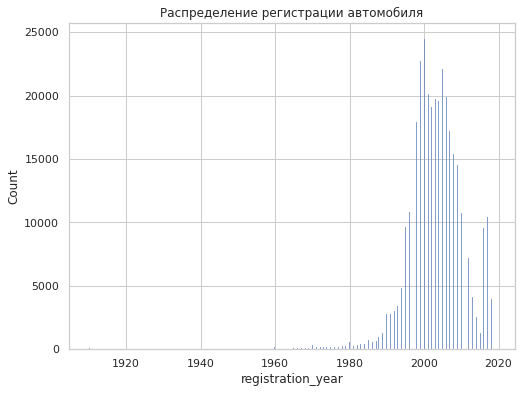

In [20]:
f, ax = plt.subplots(figsize=(8,6))

sns.histplot(x='registration_year', data=data)
ax.set_title('Распределение регистрации автомобиля');

Распределение выглядит нормальным с тяжелым правым хвостом. Так же интересно, что в правой части распределения присутствуют выбросы. Почему продается так много автомобилей с 2-3 годами пробега?

Рассмотрим признак `power`

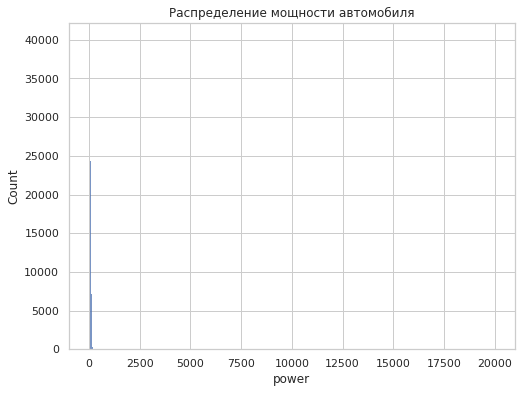

In [21]:
f, ax = plt.subplots(figsize=(8,6))

sns.histplot(x='power', data=data)
ax.set_title('Распределение мощности автомобиля');

Ограничим значения мощности справа значением 1000 л.с. (мощные серийный автомобили). Остальные строки удалим как ошибочные.

In [22]:
data = data[~(data['power'] > 1000)].reset_index(drop=True)

Так же в распределении присутсвуют значения с мощностью равной 0. Это указывает на то, что владелец автомобиля забыл указать этот параметр в объявлении. Заменим данное значение медианой по параметрам brand, bodel и fuel_type

In [23]:
data[data['power']==0]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,70435
15,450,small,1910,unknown,0,ka,5000,petrol,ford,unknown,24148
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no,44145
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no,46483
40,0,unknown,1990,unknown,0,corsa,150000,petrol,opel,unknown,56412
...,...,...,...,...,...,...,...,...,...,...,...
353868,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown,41470
353876,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown,61169
353893,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no,26624
353894,0,unknown,2005,manual,0,colt,150000,petrol,mitsubishi,yes,2694


Таких значений больше 40000. Заменим их на медиану

In [24]:
data['power'] = data['power'].replace(0, np.nan)
median_power = data.groupby(['brand', 'model', 'fuel_type'])['power'].transform('median')
data['power'] = data['power'].fillna(median_power)

Проверим количество автомобилей, для которых не было информации.

In [25]:
data['power'].isna().sum()

99

Удалим эти строки из датасета.

In [26]:
data = data.dropna(subset=['power']).reset_index(drop=True)

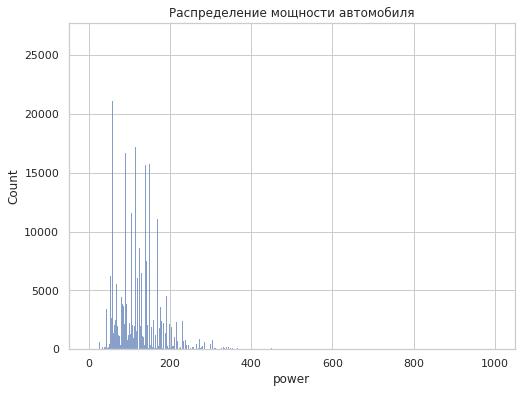

In [27]:
f, ax = plt.subplots(figsize=(8,6))

sns.histplot(x='power', data=data)
ax.set_title('Распределение мощности автомобиля');

Распределение стало выглядеть лучше, но все равно остался тяжелый правый хвост.

Рассмотрим целевой признак `price`.

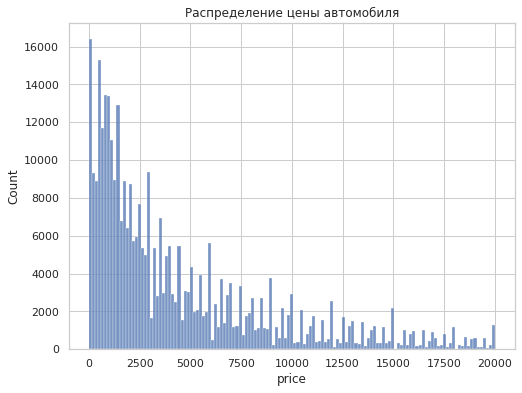

In [28]:
f, ax = plt.subplots(figsize=(8,6))

sns.histplot(x='price', data=data)
ax.set_title('Распределение цены автомобиля');

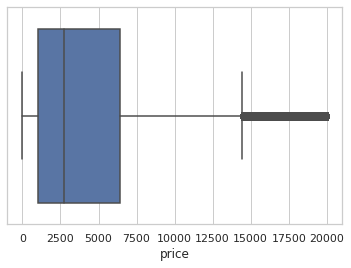

In [29]:
sns.boxplot(x='price', data=data);

Посчитаем аномальными значения, где цена меньше 200 евро.

In [30]:
data[data['price'] < 200]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,postal_code
7,0,sedan,1980,manual,50.0,other,40000,petrol,volkswagen,no,19348
40,0,unknown,1990,unknown,60.0,corsa,150000,petrol,opel,unknown,56412
59,1,suv,1994,manual,286.0,unknown,150000,unknown,sonstige_autos,unknown,53721
79,150,unknown,2016,manual,75.0,astra,150000,petrol,opel,yes,78315
89,1,sedan,1995,manual,113.0,e_klasse,150000,gasoline,mercedes_benz,no,40589
...,...,...,...,...,...,...,...,...,...,...,...
353704,150,small,1993,manual,55.0,astra,150000,petrol,opel,yes,66424
353708,0,small,1999,manual,37.0,arosa,150000,petrol,seat,yes,22559
353740,99,small,1999,manual,60.0,arosa,150000,petrol,seat,yes,91301
353769,180,unknown,1995,unknown,84.0,unknown,125000,petrol,opel,unknown,41470


In [31]:
len(data[data['price'] < 200]) / len(data) * 100

4.900791407574901

Таких значений 17339, что составляет 5% от датасета. Предлагаю удалить эти значения, потому что это целевой признак и лучше не вносить лишнее смещение в данных.

In [32]:
data = data[~(data['price'] < 200)].reset_index(drop=True)

Рассмотрим признак `postal_code`.

<AxesSubplot:xlabel='postal_code', ylabel='Count'>

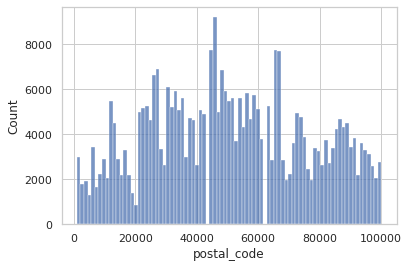

In [33]:
sns.histplot(x='postal_code', data=data)

Как видим, диапазон значений от 0 до 100000. Предположим, что почтовый индекс владельца автомобиля совпадает с местом продажи. Так же, судя по тому, что в таблице для категории `brand` используется немецкий язык, заключаем, что это индексы немецких городов. Восстановить конкретный город сложно, но первая цифра в этом коде обозначает конкретную землю. Оставим только первую цифру из кода, и таким образом, закодируем регион продажи.

In [34]:
def return_region(code):
    if len(str(code)) < 5:
        return 0
    else:
        return int(str(code)[0])

In [35]:
data['postal_code'] = data['postal_code'].apply(return_region)

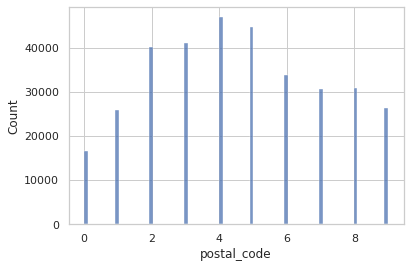

In [36]:
sns.histplot(x='postal_code', data=data);

**Вывод**

В данном разделе была произведена предобработка данных, а именно:
1. Заполнены пропущенные значения;
2. Выполнен поиск аномалий;
3. Признак post_code с города продажи был заменен на регион продажи.

Распределение численных признаков не самое хорошее, везде имеются тяжелые хвосты.

## Обучение моделей

Приступим непосредственно к обучению моделей. Будем использовать 3 семейства моделей:
1. Линейные (LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet);
2. Случайный лес (RandomForestRegressor);
3. Бустинги (CatBoostRegressor, LGBMRegressor).

Метрика качества - RMSE.

Сравнение моделей будем производить не только по точности модели, но также по скорости обучения/предсказания.

Зафиксируем seed.

In [37]:
SEED = 17

Зададим явно категориальные признаки.

In [38]:
data[categorial_features] = data[categorial_features].astype('category')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336461 entries, 0 to 336460
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              336461 non-null  int64   
 1   vehicle_type       336461 non-null  category
 2   registration_year  336461 non-null  int64   
 3   gearbox            336461 non-null  category
 4   power              336461 non-null  float64 
 5   model              336461 non-null  category
 6   kilometer          336461 non-null  int64   
 7   fuel_type          336461 non-null  category
 8   brand              336461 non-null  category
 9   not_repaired       336461 non-null  category
 10  postal_code        336461 non-null  category
dtypes: category(7), float64(1), int64(3)
memory usage: 12.8 MB


Разделим данные на обучающую, валидационную и тестовую выборки.

In [40]:
features, target = data.drop(columns=['price']), data['price']

In [41]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.6, random_state=SEED)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

In [42]:
len(data) == len(X_train) + len(X_valid) + len(X_test)

True

### Линейные модели.

Для линейных моделей необходимо произвести OHE с категориальными переменными, а так же стандартизировать данные. Создадим данный пайплайн.

In [43]:
num_pipe_lr = make_pipeline(
    StandardScaler()
)

cat_pipe_lr = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

preprocessor = make_column_transformer(
    (num_pipe_lr, selector(dtype_include="number")),
    (cat_pipe_lr, selector(dtype_include="category"))
)

In [44]:
results = []

def append_result(model_name, params, fit_time, predict_time, RMSE, result_list, verbose=True):
    
    result_dict = {
        'Модель' : model_name,
        'Параметры модели' : params,
        'Время обучения' : fit_time,
        'Время предсказания' : predict_time,
        'RMSE модели' : RMSE
    }
    
    result_list.append(result_dict)
    
    if verbose:
        return pd.DataFrame(result_list)

**Линейная регрессия**

In [45]:
start_time = time()

lin_reg = make_pipeline(preprocessor, LinearRegression())
lin_reg.fit(X_train, y_train)
end_fit_time = time()

predict_lin_reg = lin_reg.predict(X_valid)
end_predict_time = time()

rmse_lin_reg = mean_squared_error(y_valid, predict_lin_reg, squared=False)

append_result('LR', np.nan, end_fit_time - start_time, end_predict_time - end_fit_time, rmse_lin_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472


**Lasso**

In [46]:
start_time = time()

lasso_reg = make_pipeline(preprocessor, Lasso())
lasso_reg.fit(X_train, y_train)
end_fit_time = time()

predict_lasso_reg = lasso_reg.predict(X_valid)
end_predict_time = time()

rmse_lasso_reg = mean_squared_error(y_valid, predict_lasso_reg, squared=False)

append_result('Lasso', np.nan, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_lasso_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527


**Ridge**

In [47]:
start_time = time()

ridge_reg = make_pipeline(preprocessor, Ridge())
ridge_reg.fit(X_train, y_train)
end_fit_time = time()

predict_ridge_reg = ridge_reg.predict(X_valid)
end_predict_time = time()

rmse_ridge_reg = mean_squared_error(y_valid, predict_ridge_reg, squared=False)

append_result('Ridge', np.nan, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_ridge_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784


**ElasticNet**

In [48]:
start_time = time()

en_reg = make_pipeline(preprocessor, ElasticNet())
en_reg.fit(X_train, y_train)
end_fit_time = time()

predict_en_reg = en_reg.predict(X_valid)
end_predict_time = time()

rmse_en_reg = mean_squared_error(y_valid, predict_en_reg, squared=False)

append_result('ElasticNet', np.nan, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_en_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194


**SGDRegressor**

In [49]:
params = {
    'penalty' : 'l2',
    'max_iter' : 1000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (1)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353


In [50]:
params = {
    'penalty' : 'l1',
    'max_iter' : 1000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (2)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765


In [51]:
params = {
    'penalty' : 'elasticnet',
    'max_iter' : 1000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (3)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765
6,SGD (3),"{'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 17}",3.382794,0.151242,2664.424899


In [52]:
params = {
    'penalty' : 'l1',
    'max_iter' : 5000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (4)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765
6,SGD (3),"{'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 17}",3.382794,0.151242,2664.424899
7,SGD (4),"{'penalty': 'l1', 'max_iter': 5000, 'random_state': 17}",3.491859,0.155374,2662.632765


In [53]:
params = {
    'penalty' : 'l2',
    'max_iter' : 5000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (5)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765
6,SGD (3),"{'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 17}",3.382794,0.151242,2664.424899
7,SGD (4),"{'penalty': 'l1', 'max_iter': 5000, 'random_state': 17}",3.491859,0.155374,2662.632765
8,SGD (5),"{'penalty': 'l2', 'max_iter': 5000, 'random_state': 17}",2.944357,0.150583,2664.781353


In [54]:
params = {
    'penalty' : 'elasticnet',
    'max_iter' : 5000,
    'random_state' : SEED
}

start_time = time()

sgd_reg = make_pipeline(preprocessor, SGDRegressor(**params))
sgd_reg.fit(X_train, y_train)
end_fit_time = time()

predict_sgd_reg = sgd_reg.predict(X_valid)
end_predict_time = time()

rmse_sgd_reg = mean_squared_error(y_valid, predict_sgd_reg, squared=False)

append_result('SGD (6)', params, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_sgd_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765
6,SGD (3),"{'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 17}",3.382794,0.151242,2664.424899
7,SGD (4),"{'penalty': 'l1', 'max_iter': 5000, 'random_state': 17}",3.491859,0.155374,2662.632765
8,SGD (5),"{'penalty': 'l2', 'max_iter': 5000, 'random_state': 17}",2.944357,0.150583,2664.781353
9,SGD (6),"{'penalty': 'elasticnet', 'max_iter': 5000, 'random_state': 17}",3.321900,0.144836,2664.424899


### Случайный лес

In [55]:
cat_pipe_rf = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999),
)

preprocessor_rf = make_column_transformer(
    (cat_pipe_rf, selector(dtype_include="category"))
)

In [56]:
start_time = time()

rf_reg = make_pipeline(preprocessor_rf, RandomForestRegressor(random_state=SEED))
rf_reg.fit(X_train, y_train)
end_fit_time = time()

predict_rf_reg = rf_reg.predict(X_valid)
end_predict_time = time()

rmse_rf_reg = mean_squared_error(y_valid, predict_rf_reg, squared=False)

append_result('RF', np.nan, end_fit_time - start_time, 
              end_predict_time - end_fit_time, rmse_rf_reg, results)

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LR,NaN,19.878958,0.272924,2656.091472
1,Lasso,NaN,13.410662,0.267439,2686.119527
2,Ridge,NaN,0.438302,0.149393,2656.704784
3,ElasticNet,NaN,1.019961,0.266573,3188.622194
4,SGD (1),"{'penalty': 'l2', 'max_iter': 1000, 'random_state': 17}",2.977339,0.153687,2664.781353
5,SGD (2),"{'penalty': 'l1', 'max_iter': 1000, 'random_state': 17}",3.485225,0.148529,2662.632765
6,SGD (3),"{'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 17}",3.382794,0.151242,2664.424899
7,SGD (4),"{'penalty': 'l1', 'max_iter': 5000, 'random_state': 17}",3.491859,0.155374,2662.632765
8,SGD (5),"{'penalty': 'l2', 'max_iter': 5000, 'random_state': 17}",2.944357,0.150583,2664.781353
9,SGD (6),"{'penalty': 'elasticnet', 'max_iter': 5000, 'random_state': 17}",3.321900,0.144836,2664.424899


In [57]:
results_lin_rf = pd.DataFrame(results)

In [58]:
results = []

### CatBoost

In [59]:
for iteration in range(10, 101, 20):
    
    for depth in range(3, 6):
        
        params = {
            'random_state' : SEED,
            'depth' : depth,
            'iterations' : iteration,
            'verbose' : False,
            'loss_function' : 'RMSE',
            'cat_features' : categorial_features
        }
        
        cb_reg = CatBoostRegressor(**params)
        
        start_time = time()
        cb_reg.fit(X_train, y_train)
        end_fit_time = time()
        
        predict_cb_reg = cb_reg.predict(X_valid)
        end_predict_time = time()
        
        rmse_cb_reg = mean_squared_error(y_valid, predict_cb_reg, squared=False)
        
        append_result('CatBoost', params, end_fit_time - start_time,
                      end_predict_time - end_fit_time, rmse_cb_reg, results, False)
        
results_cat_boost = pd.DataFrame(results)

In [60]:
results_cat_boost

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,CatBoost,"{'random_state': 17, 'depth': 3, 'iterations': 10, 'verbose':...",0.860601,0.060556,2197.106957
1,CatBoost,"{'random_state': 17, 'depth': 4, 'iterations': 10, 'verbose':...",0.710126,0.059629,2090.451317
2,CatBoost,"{'random_state': 17, 'depth': 5, 'iterations': 10, 'verbose':...",0.783773,0.060973,2026.656119
3,CatBoost,"{'random_state': 17, 'depth': 3, 'iterations': 30, 'verbose':...",1.240919,0.062311,1976.258405
4,CatBoost,"{'random_state': 17, 'depth': 4, 'iterations': 30, 'verbose':...",1.479724,0.075582,1930.451079
5,CatBoost,"{'random_state': 17, 'depth': 5, 'iterations': 30, 'verbose':...",1.859872,0.066733,1867.798499
6,CatBoost,"{'random_state': 17, 'depth': 3, 'iterations': 50, 'verbose':...",1.892931,0.066822,1907.612784
7,CatBoost,"{'random_state': 17, 'depth': 4, 'iterations': 50, 'verbose':...",2.175433,0.068137,1858.426388
8,CatBoost,"{'random_state': 17, 'depth': 5, 'iterations': 50, 'verbose':...",2.596943,0.078984,1820.197781
9,CatBoost,"{'random_state': 17, 'depth': 3, 'iterations': 70, 'verbose':...",2.646838,0.090229,1872.904452


In [61]:
results = []

### LGBM

In [62]:
for estimator in range(10, 101, 20):
    
    for depth in range(3, 6):
        
        params = {
            'random_state' : SEED,
            'max_depth' : depth,
            'n_estimators' : estimator,
            'metric' : 'rmse',
            'categorical_feature' : categorial_features
        }
        
        lgbm_reg = LGBMRegressor(**params)
        
        start_time = time()
        lgbm_reg.fit(X_train, y_train)
        end_fit_time = time()
        
        predict_lgbm_reg = lgbm_reg.predict(X_valid)
        end_predict_time = time()
        
        rmse_lgbm_reg = mean_squared_error(y_valid, predict_lgbm_reg, squared=False)
        
        append_result('LGBM', params, end_fit_time - start_time,
                      end_predict_time - end_fit_time, rmse_lgbm_reg, results, False)
        
results_lgbm_boost = pd.DataFrame(results)

In [63]:
results_lgbm_boost

,Модель,Параметры модели,Время обучения,Время предсказания,RMSE модели
0,LGBM,"{'random_state': 17, 'max_depth': 3, 'n_estimators': 10, 'met...",0.673998,0.190986,2951.039123
1,LGBM,"{'random_state': 17, 'max_depth': 4, 'n_estimators': 10, 'met...",0.701165,0.100949,2732.555679
2,LGBM,"{'random_state': 17, 'max_depth': 5, 'n_estimators': 10, 'met...",0.599305,0.103821,2596.765867
3,LGBM,"{'random_state': 17, 'max_depth': 3, 'n_estimators': 30, 'met...",1.294506,0.200062,2134.219577
4,LGBM,"{'random_state': 17, 'max_depth': 4, 'n_estimators': 30, 'met...",2.901085,0.201805,1965.142891
5,LGBM,"{'random_state': 17, 'max_depth': 5, 'n_estimators': 30, 'met...",1.790770,0.297044,1860.964202
6,LGBM,"{'random_state': 17, 'max_depth': 3, 'n_estimators': 50, 'met...",1.003816,0.299387,1951.250788
7,LGBM,"{'random_state': 17, 'max_depth': 4, 'n_estimators': 50, 'met...",1.398649,0.398070,1841.207817
8,LGBM,"{'random_state': 17, 'max_depth': 5, 'n_estimators': 50, 'met...",1.595349,0.410369,1764.229567
9,LGBM,"{'random_state': 17, 'max_depth': 3, 'n_estimators': 70, 'met...",1.392196,0.404330,1882.799589


In [64]:
del results

## Анализ моделей

Исходя из полученных результатов можно сказать следующее:

1. Лучшей из линейных моделей оказалась Ridge регрессия с результатами:
* Время обучения - 0.472689 с.
* Время предсказания - 0.153370 с.
* RMSE - 2656.704784 евро.

2. Случайный лес оказался самым плохим алгоритмом с результатом:
* Время обучения - 15.967955 с.
* Время предсказания - 2.501721 с.
* RMSE - 3519.871099 евро.

3. Бустинги показали себя намного лучше, а именно:

    1. Лучшая модель CatBoost (по метрике RMSE):
        * Время обучения - 4.780523 с.
        * Время предсказания - 0.074558 с.
        * RMSE - 1768.988516 евро.
    2. Лучшая модель LGBM (по метрике RMSE):
        * Время обучения - 2.203731 с.
        * Время предсказания - 0.608196 с.
        * RMSE - 1734.481529 евро.
        
Важно учесть, что нам важна не только метрика RMSE, а так же скорость обучения и предсказания. Таким образом, предлагаю выбрать модель CatBoost с параметрами `depth=5`, `iterations=30` и результатами:
* Время обучения - 1.727666 с.
* Время предсказания - 0.071033 с.
* RMSE - 1867.798499 евро.

Проверим, как данная модель работает на тестовой выборке.

In [65]:
final_model = CatBoostRegressor(depth=5, iterations=30, random_state=SEED,
                                loss_function='RMSE', verbose=False,
                                cat_features=categorial_features)

start_time = time()
final_model.fit(X_train, y_train)
end_fit_time = time()

predict_final_model = final_model.predict(X_test)
end_predict_time = time()

rmse_final_model = mean_squared_error(y_test, predict_final_model, squared=False)

print('Время обучения', end_fit_time - start_time, 'с')
print('Время предсказания', end_predict_time - end_fit_time, 'с')
print('RMSE модели', rmse_final_model)

Время обучения 1.7477822303771973 с
Время предсказания 0.06838274002075195 с
RMSE модели 1863.252225423828


Сравним полученный RMSE со случаной моделью.

In [66]:
dummy_regressor = DummyRegressor(strategy='mean')

dummy_regressor.fit(X_train, y_train)

predict_dummy = dummy_regressor.predict(X_test)

rmse_dummy = mean_squared_error(y_test, predict_dummy, squared=False)

print('RMSE случайной модели', rmse_dummy)

RMSE случайной модели 4514.275301955842


## Вывод

В данном проекте была задача по предсказанию стоимости автомобиля по историческим данным.

В ходе проекта был произведен осмотр данных, а так же их предобработка: заполнены пропуски, удалены дубликаты и аномалии.

Предсказания цен производились с помощью трех семейств моделей:
1. Линейные модели;
2. Случайный лес;
3. Бустинги.

Лучше всего себя показали бустинги, как по качеству, так и по скорости обучения и предсказаний.

LGBM и CatBoost конкурентные виды бустингов, но CatBoost работает значительно быстрее при малом количестве деревьев. При увеличении числа деревьев результаты становятся сопостовимыми.

Исходя из анализа моделей была выбрана модель CatBoostRegressor с параметрами `depth=5`, `iterations=30`.

Результат данной модели на валидации:
* Время обучения - 1.727666 с.
* Время предсказания - 0.071033 с.
* RMSE - 1867.798499 евро.

Результат данной модели на тестовой выборке:
* Время обучения - 1.8717224 с.
* Время предсказания - 0.0761792 с.
* RMSE - 1863.252225 евро.

Модель показала себя стабильной и не переобучилась.

Также сравнили данную модель со случайной. Метрика RMSE у случайной модели равна 4514.2753. Наша модель обладает значительно более сильной предсказательной способностью.

